In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.models import shufflenet_v2_x0_5

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results_v1/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('Shuffle Net Classifier. First Test.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

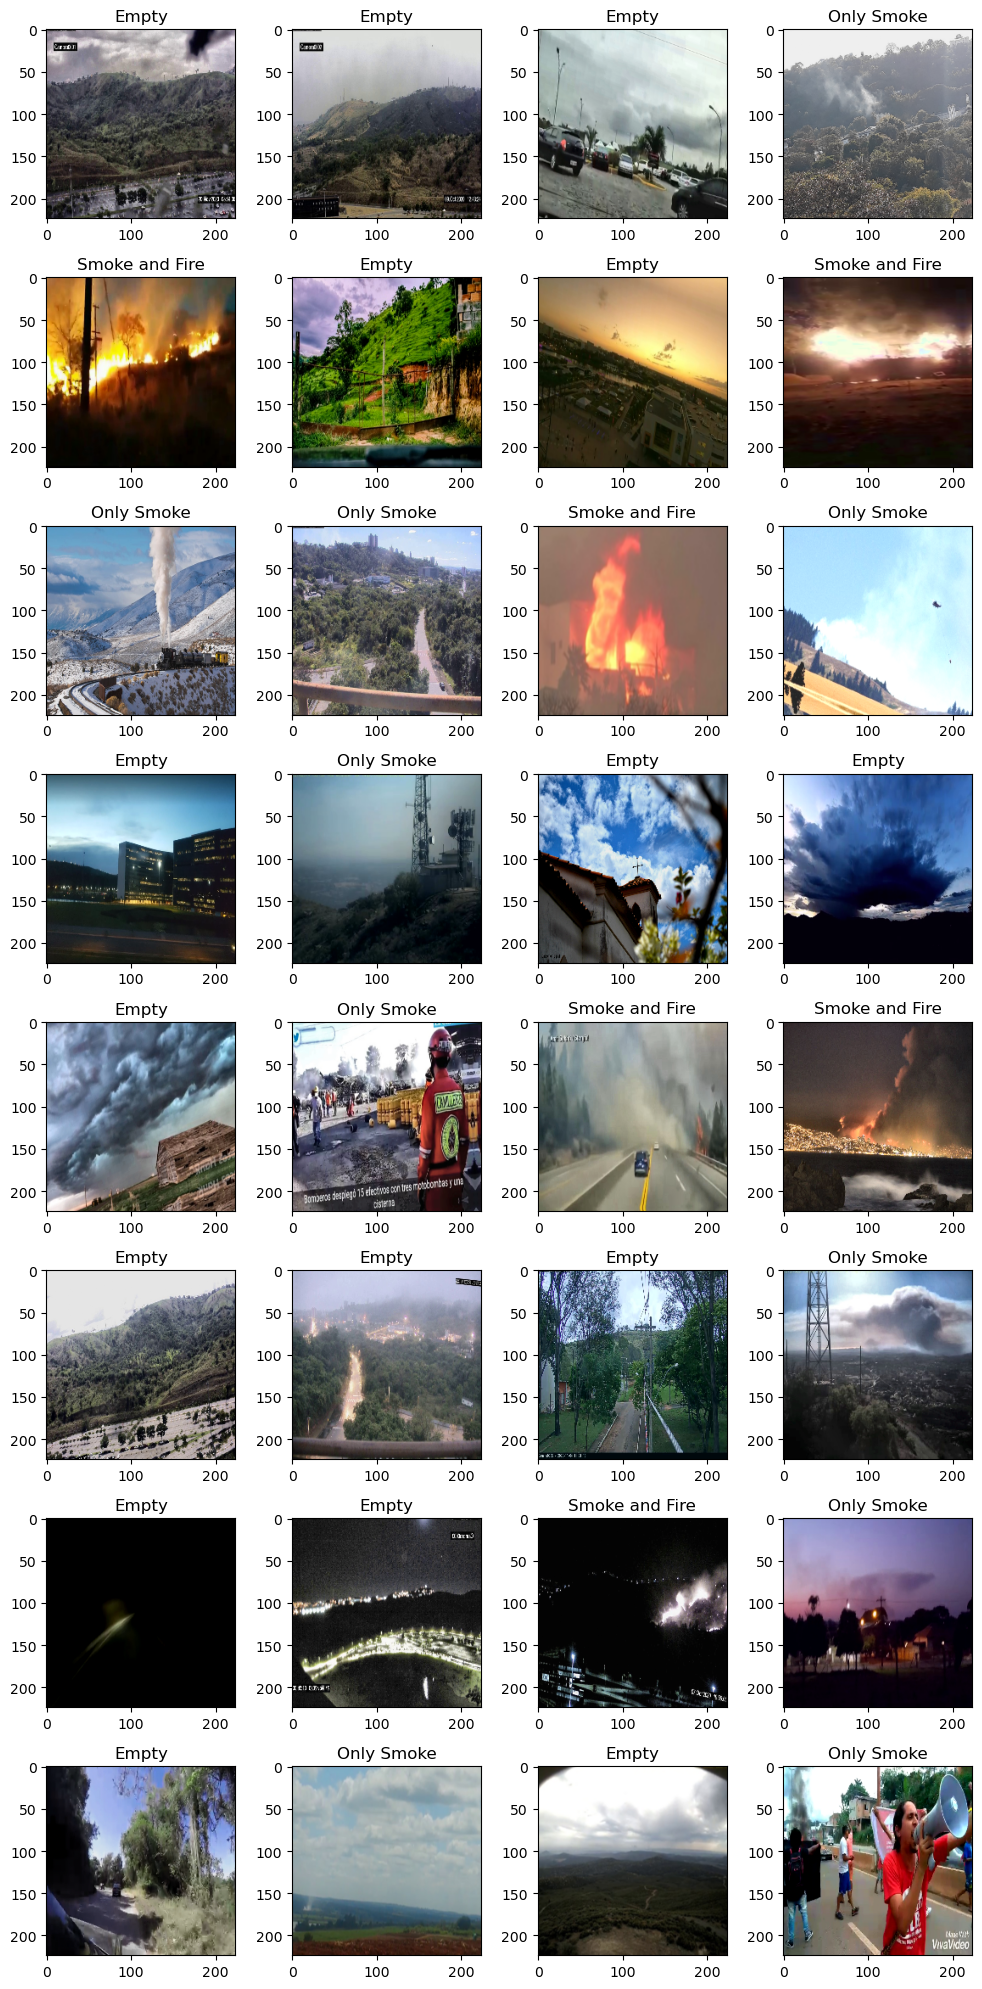

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: ShuffleNet Pretrained

In [10]:
class PRETRAINED_SHUFFLE(nn.Module):
    def __init__(self, base_model, last_channels, num_classes, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.last_channels = last_channels
        
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

    # TODO: initizalize only head layers
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_in',
    #                 nonlinearity='relu'
    #             )
    #             if m.bias is not None:
    #                     nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             nn.init.constant_(m.bias, 0)

    # [xc1, yc1, w1, h1, conf1, xc2, yc2, w2, h2, conf2, smoke, fire]
    # [0 ................. 4,    5 ................ 9      10    11 ]
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce(predictions[..., 0],
                              ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce(predictions[..., 1],
                             ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

#MODEL = "BED"
MODEL = "SHUFFLE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-3
EPOCHS = 20 #100
NUM_WORKERS = 8
PIN_MEMORY = True
PRETRAINED = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    #LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"
    LOAD_MODEL_FILE = "squeezeNet/" + "SQUEEZE_best_classifier.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Model Setup

In [13]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''

def setup_model(pretrained, load, model_name):
    if pretrained == True:
        if model_name == "SHUFFLE":
            print("Using SHUFFLE Classifier")
            logger.info("Using SHUFFLE Classifier")
        
            base_model = shufflenet_v2_x0_5(weights='IMAGENET1K_V1')
            print(list(base_model.children())[-1])
            for name, layer in base_model.named_modules():
                if isinstance(layer, nn.Linear):
                    last_channels = layer.in_features
                    print(f'Model Pretrained has {last_channels} in features in last layer')
                    logger.info(f'Model Pretrained has {last_channels} in features in last layer')
            for param in base_model.parameters():
                param.requires_grad = False
            
            model = PRETRAINED_SHUFFLE(base_model, last_channels, num_classes=N_CLASSES).to(DEVICE)   

            return model
    else:
        print("Wrong Model")
        logger.info("Wrong Model")
        raise SystemExit("Wrong Model")

model = setup_model(pretrained=PRETRAINED, load=LOAD_MODEL, model_name=MODEL)

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using SHUFFLE Classifier
Linear(in_features=1024, out_features=1000, bias=True)
Model Pretrained has 1024 in features in last layer
Model shape is tensor([[-0.2117,  0.2204],
        [-0.2125,  0.2199],
        [-0.2134,  0.2284],
        [-0.2157,  0.2211]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
PRETRAINED_SHUFFLE(
  (base_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 24

# Metrics

In [14]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [15]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [16]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [17]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Main Function

In [18]:
''' ============================
    Print Config Values
============================ '''
print(f'Device: {DEVICE}')
print(f'Learning Rate: {LEARNING_RATE}')
print(f'Weight Decay: {WEIGHT_DECAY}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
print(f'W: {IMG_W}\nH: {IMG_H}')

logger.info(f'Device: {DEVICE}')
logger.info(f'Learning Rate: {LEARNING_RATE}')
logger.info(f'Weight Decay: {WEIGHT_DECAY}')
logger.info(f'Batch Size: {BATCH_SIZE}')
logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
logger.info(f'W: {IMG_W}\nH: {IMG_H}')

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224


## Loss Funtion Setup

In [19]:
# LOSS FUNCTION
if LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'Loss Function: BCE')
    loss_fn = BCE_LOSS(device=DEVICE)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE


In [20]:
def train_model(model, model_name, optimizer, scheduler, first_epoch=0, epochs = EPOCHS):
   
    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = first_epoch

    if LOAD_MODEL == False:
        if model_name == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif model_name == "SQUEEZE":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        else: 
            print("Pretrained Weights")
            logger.info("Pretrained Weights")            
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, start_epoch + epochs):

        print(f'\n=== EPOCH {epoch}/{start_epoch + epochs-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{start_epoch + epochs-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + model_name + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + model_name + '_best_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + model_name + '_last_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [21]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_freeze = train_model(model=model, 
                               model_name=MODEL+'_FREEZE_',
                               optimizer=optimizer, 
                               scheduler=scheduler, 
                               epochs = EPOCHS)

Starting script


***Start Training: 17:29:58

Pretrained Weights

=== EPOCH 0/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.314      |40.338      |28.976      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.816      |36.176      |19.640      

SMOKE -> Precision: 0.748 - Recall: 0.680 - Accuracy: 0.736 - F1: 0.712
FIRE -> Precision: 0.858 - Recall: 0.720 - Accuracy: 0.897 - F1: 0.783

Saving model with new best validation loss: 55.816

=== EPOCH 1/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.796      |35.036      |18.760      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.794      |32.637      |15.156      

SMOKE -> Precision: 0.778 - Recall: 0.696 - Accuracy: 0.758 - F1: 0.734
FIRE -> Precision: 0.855 - Recall: 0.789 - Accuracy: 0.911 - F1: 0.821

Saving model with new best validation loss: 47.794

=== EPOCH 2/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.283      |33.012      |16.271      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.285      |30.910      |13.375      

SMOKE -> Precision: 0.818 - Recall: 0.689 - Accuracy: 0.777 - F1: 0.748
FIRE -> Precision: 0.857 - Recall: 0.817 - Accuracy: 0.917 - F1: 0.837

Saving model with new best validation loss: 44.285

=== EPOCH 3/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.123      |31.870      |15.252      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.032      |29.511      |12.521      

SMOKE -> Precision: 0.803 - Recall: 0.768 - Accuracy: 0.798 - F1: 0.785
FIRE -> Precision: 0.863 - Recall: 0.841 - Accuracy: 0.924 - F1: 0.852

Saving model with new best validation loss: 42.032

=== EPOCH 4/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.625      |31.018      |14.607      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.745      |28.895      |11.850      

SMOKE -> Precision: 0.773 - Recall: 0.813 - Accuracy: 0.795 - F1: 0.793
FIRE -> Precision: 0.892 - Recall: 0.833 - Accuracy: 0.931 - F1: 0.862

Saving model with new best validation loss: 40.745

=== EPOCH 5/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.584      |30.548      |14.036      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.713      |28.086      |11.627      

SMOKE -> Precision: 0.825 - Recall: 0.743 - Accuracy: 0.800 - F1: 0.782
FIRE -> Precision: 0.874 - Recall: 0.860 - Accuracy: 0.932 - F1: 0.867

Saving model with new best validation loss: 39.713

=== EPOCH 6/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.541      |30.020      |13.521      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.499      |27.410      |11.090      

SMOKE -> Precision: 0.821 - Recall: 0.778 - Accuracy: 0.811 - F1: 0.799
FIRE -> Precision: 0.894 - Recall: 0.857 - Accuracy: 0.937 - F1: 0.875

Saving model with new best validation loss: 38.499

=== EPOCH 7/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.730      |30.100      |13.630      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.900      |27.055      |10.844      

SMOKE -> Precision: 0.823 - Recall: 0.760 - Accuracy: 0.806 - F1: 0.790
FIRE -> Precision: 0.889 - Recall: 0.858 - Accuracy: 0.935 - F1: 0.873

Saving model with new best validation loss: 37.900

=== EPOCH 8/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.316      |29.770      |13.545      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.450      |26.807      |10.643      

SMOKE -> Precision: 0.802 - Recall: 0.810 - Accuracy: 0.812 - F1: 0.806
FIRE -> Precision: 0.894 - Recall: 0.864 - Accuracy: 0.938 - F1: 0.879

Saving model with new best validation loss: 37.450

=== EPOCH 9/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.885      |29.546      |13.339      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.967      |26.522      |10.446      

SMOKE -> Precision: 0.840 - Recall: 0.762 - Accuracy: 0.816 - F1: 0.799
FIRE -> Precision: 0.906 - Recall: 0.861 - Accuracy: 0.941 - F1: 0.883

Saving model with new best validation loss: 36.967

=== EPOCH 10/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.140      |29.114      |13.026      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.304      |26.037      |10.268      

SMOKE -> Precision: 0.836 - Recall: 0.778 - Accuracy: 0.820 - F1: 0.806
FIRE -> Precision: 0.909 - Recall: 0.854 - Accuracy: 0.940 - F1: 0.881

Saving model with new best validation loss: 36.304

=== EPOCH 11/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.129      |29.201      |12.929      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.259      |26.071      |10.188      

SMOKE -> Precision: 0.827 - Recall: 0.786 - Accuracy: 0.818 - F1: 0.806
FIRE -> Precision: 0.895 - Recall: 0.873 - Accuracy: 0.941 - F1: 0.884

Saving model with new best validation loss: 36.259

=== EPOCH 12/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.316      |29.275      |13.041      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.116      |25.932      |10.185      

SMOKE -> Precision: 0.840 - Recall: 0.770 - Accuracy: 0.819 - F1: 0.804
FIRE -> Precision: 0.893 - Recall: 0.885 - Accuracy: 0.943 - F1: 0.889

Saving model with new best validation loss: 36.116

=== EPOCH 13/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.193      |29.281      |12.913      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.779      |25.681      |10.099      

SMOKE -> Precision: 0.833 - Recall: 0.780 - Accuracy: 0.819 - F1: 0.806
FIRE -> Precision: 0.894 - Recall: 0.881 - Accuracy: 0.942 - F1: 0.887

Saving model with new best validation loss: 35.779

=== EPOCH 14/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.793      |28.693      |13.100      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.336      |25.415      |9.920       

SMOKE -> Precision: 0.833 - Recall: 0.796 - Accuracy: 0.825 - F1: 0.814
FIRE -> Precision: 0.908 - Recall: 0.862 - Accuracy: 0.942 - F1: 0.884

Saving model with new best validation loss: 35.336

=== EPOCH 15/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.297      |28.637      |12.660      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.467      |25.561      |9.906       

SMOKE -> Precision: 0.803 - Recall: 0.840 - Accuracy: 0.824 - F1: 0.821
FIRE -> Precision: 0.895 - Recall: 0.882 - Accuracy: 0.943 - F1: 0.888

=== EPOCH 16/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.547      |28.804      |12.743      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.098      |25.337      |9.761       

SMOKE -> Precision: 0.825 - Recall: 0.810 - Accuracy: 0.826 - F1: 0.818
FIRE -> Precision: 0.911 - Recall: 0.860 - Accuracy: 0.942 - F1: 0.885

Saving model with new best validation loss: 35.098

=== EPOCH 17/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.680      |28.813      |12.867      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.400      |25.417      |9.983       

SMOKE -> Precision: 0.842 - Recall: 0.784 - Accuracy: 0.825 - F1: 0.812
FIRE -> Precision: 0.884 - Recall: 0.899 - Accuracy: 0.943 - F1: 0.891

=== EPOCH 18/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.266      |28.665      |12.601      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.053      |25.341      |9.712       

SMOKE -> Precision: 0.801 - Recall: 0.848 - Accuracy: 0.825 - F1: 0.824
FIRE -> Precision: 0.904 - Recall: 0.877 - Accuracy: 0.944 - F1: 0.890

Saving model with new best validation loss: 35.053

=== EPOCH 19/19 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.107      |28.585      |12.521      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.744      |25.056      |9.688       

SMOKE -> Precision: 0.843 - Recall: 0.788 - Accuracy: 0.827 - F1: 0.815
FIRE -> Precision: 0.898 - Recall: 0.878 - Accuracy: 0.943 - F1: 0.888

Saving model with new best validation loss: 34.744

***Script finished: 17:38:44

Time elapsed: 0:08:45.624862


# Plot Results

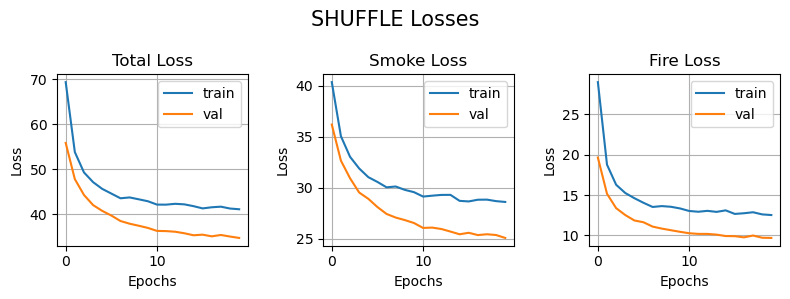

In [22]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()

# Fine Tuning

In [23]:
FIRST_EPOCH = EPOCHS
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 140 

In [24]:
for param in model_freeze.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_freeze.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-7)
# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model_freeze.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model_freeze.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')


Trainable parameters = 374626
Total parameters = 374626



In [25]:
if __name__ == "__main__":
    print("Starting Fine Tuning\n")
    logger.info("Starting script\n")
    model_freeze = train_model(model=model_freeze, 
                               model_name=MODEL+'_FineTune',
                               optimizer=optimizer, 
                               scheduler=scheduler, 
                               first_epoch = FIRST_EPOCH,
                               epochs = EPOCHS)

Starting Fine Tuning


***Start Training: 17:38:44

Pretrained Weights

=== EPOCH 20/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.913      |27.672      |12.241      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.741      |24.353      |9.388       

SMOKE -> Precision: 0.835 - Recall: 0.821 - Accuracy: 0.836 - F1: 0.828
FIRE -> Precision: 0.898 - Recall: 0.899 - Accuracy: 0.948 - F1: 0.899

Saving model with new best validation loss: 33.741

=== EPOCH 21/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.279      |27.351      |11.928      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.609      |23.585      |9.024       

SMOKE -> Precision: 0.854 - Recall: 0.807 - Accuracy: 0.841 - F1: 0.830
FIRE -> Precision: 0.917 - Recall: 0.877 - Accuracy: 0.948 - F1: 0.897

Saving model with new best validation loss: 32.609

=== EPOCH 22/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.835      |26.372      |11.463      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.909      |23.070      |8.839       

SMOKE -> Precision: 0.855 - Recall: 0.814 - Accuracy: 0.844 - F1: 0.834
FIRE -> Precision: 0.913 - Recall: 0.893 - Accuracy: 0.950 - F1: 0.903

Saving model with new best validation loss: 31.909

=== EPOCH 23/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.733      |25.527      |11.205      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.137      |22.468      |8.669       

SMOKE -> Precision: 0.862 - Recall: 0.826 - Accuracy: 0.853 - F1: 0.844
FIRE -> Precision: 0.911 - Recall: 0.901 - Accuracy: 0.951 - F1: 0.906

Saving model with new best validation loss: 31.137

=== EPOCH 24/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.384      |25.376      |11.008      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.450      |21.931      |8.519       

SMOKE -> Precision: 0.862 - Recall: 0.841 - Accuracy: 0.859 - F1: 0.852
FIRE -> Precision: 0.911 - Recall: 0.899 - Accuracy: 0.951 - F1: 0.905

Saving model with new best validation loss: 30.450

=== EPOCH 25/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.803      |24.976      |10.827      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.045      |21.685      |8.360       

SMOKE -> Precision: 0.876 - Recall: 0.825 - Accuracy: 0.860 - F1: 0.850
FIRE -> Precision: 0.930 - Recall: 0.877 - Accuracy: 0.951 - F1: 0.903

Saving model with new best validation loss: 30.045

=== EPOCH 26/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.353      |24.518      |10.835      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.505      |21.244      |8.261       

SMOKE -> Precision: 0.855 - Recall: 0.874 - Accuracy: 0.868 - F1: 0.865
FIRE -> Precision: 0.915 - Recall: 0.906 - Accuracy: 0.954 - F1: 0.910

Saving model with new best validation loss: 29.505

=== EPOCH 27/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.683      |24.308      |10.375      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.909      |20.758      |8.151       

SMOKE -> Precision: 0.876 - Recall: 0.850 - Accuracy: 0.870 - F1: 0.863
FIRE -> Precision: 0.914 - Recall: 0.906 - Accuracy: 0.954 - F1: 0.910

Saving model with new best validation loss: 28.909

=== EPOCH 28/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.153      |23.848      |10.305      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.698      |20.630      |8.068       

SMOKE -> Precision: 0.893 - Recall: 0.828 - Accuracy: 0.869 - F1: 0.859
FIRE -> Precision: 0.916 - Recall: 0.900 - Accuracy: 0.953 - F1: 0.908

Saving model with new best validation loss: 28.698

=== EPOCH 29/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.340      |23.259      |10.081      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.093      |20.174      |7.919       

SMOKE -> Precision: 0.879 - Recall: 0.855 - Accuracy: 0.874 - F1: 0.867
FIRE -> Precision: 0.922 - Recall: 0.901 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 28.093

=== EPOCH 30/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.213      |23.111      |10.102      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.687      |19.908      |7.779       

SMOKE -> Precision: 0.884 - Recall: 0.857 - Accuracy: 0.877 - F1: 0.871
FIRE -> Precision: 0.927 - Recall: 0.894 - Accuracy: 0.954 - F1: 0.910

Saving model with new best validation loss: 27.687

=== EPOCH 31/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.555      |22.678      |9.876       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.390      |19.594      |7.797       

SMOKE -> Precision: 0.879 - Recall: 0.864 - Accuracy: 0.878 - F1: 0.872
FIRE -> Precision: 0.921 - Recall: 0.909 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 27.390

=== EPOCH 32/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.899      |22.137      |9.762       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.100      |19.341      |7.759       

SMOKE -> Precision: 0.880 - Recall: 0.863 - Accuracy: 0.877 - F1: 0.871
FIRE -> Precision: 0.913 - Recall: 0.918 - Accuracy: 0.956 - F1: 0.916

Saving model with new best validation loss: 27.100

=== EPOCH 33/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.268      |22.411      |9.857       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.523      |18.936      |7.587       

SMOKE -> Precision: 0.887 - Recall: 0.865 - Accuracy: 0.882 - F1: 0.876
FIRE -> Precision: 0.929 - Recall: 0.905 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 26.523

=== EPOCH 34/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.247      |21.561      |9.686       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.301      |18.723      |7.578       

SMOKE -> Precision: 0.889 - Recall: 0.872 - Accuracy: 0.886 - F1: 0.881
FIRE -> Precision: 0.919 - Recall: 0.914 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 26.301

=== EPOCH 35/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.237      |21.729      |9.509       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.962      |18.540      |7.421       

SMOKE -> Precision: 0.885 - Recall: 0.876 - Accuracy: 0.886 - F1: 0.881
FIRE -> Precision: 0.938 - Recall: 0.901 - Accuracy: 0.959 - F1: 0.919

Saving model with new best validation loss: 25.962

=== EPOCH 36/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.552      |21.138      |9.414       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.649      |18.286      |7.364       

SMOKE -> Precision: 0.892 - Recall: 0.873 - Accuracy: 0.888 - F1: 0.882
FIRE -> Precision: 0.932 - Recall: 0.905 - Accuracy: 0.958 - F1: 0.919

Saving model with new best validation loss: 25.649

=== EPOCH 37/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.157      |20.968      |9.189       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.600      |18.233      |7.367       

SMOKE -> Precision: 0.887 - Recall: 0.873 - Accuracy: 0.885 - F1: 0.880
FIRE -> Precision: 0.927 - Recall: 0.911 - Accuracy: 0.958 - F1: 0.919

Saving model with new best validation loss: 25.600

=== EPOCH 38/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.004      |21.047      |8.957       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.257      |18.009      |7.248       

SMOKE -> Precision: 0.893 - Recall: 0.873 - Accuracy: 0.888 - F1: 0.883
FIRE -> Precision: 0.935 - Recall: 0.905 - Accuracy: 0.959 - F1: 0.919

Saving model with new best validation loss: 25.257

=== EPOCH 39/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.592      |20.738      |8.854       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.943      |17.767      |7.177       

SMOKE -> Precision: 0.891 - Recall: 0.880 - Accuracy: 0.890 - F1: 0.885
FIRE -> Precision: 0.934 - Recall: 0.910 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 24.943

=== EPOCH 40/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.258      |20.409      |8.849       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.621      |17.474      |7.147       

SMOKE -> Precision: 0.905 - Recall: 0.872 - Accuracy: 0.894 - F1: 0.888
FIRE -> Precision: 0.929 - Recall: 0.914 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 24.621

=== EPOCH 41/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.659      |20.009      |8.651       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.431      |17.323      |7.108       

SMOKE -> Precision: 0.898 - Recall: 0.881 - Accuracy: 0.894 - F1: 0.889
FIRE -> Precision: 0.928 - Recall: 0.923 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 24.431

=== EPOCH 42/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.154      |20.157      |8.997       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.119      |17.120      |7.000       

SMOKE -> Precision: 0.897 - Recall: 0.886 - Accuracy: 0.896 - F1: 0.891
FIRE -> Precision: 0.935 - Recall: 0.913 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 24.119

=== EPOCH 43/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.384      |19.549      |8.835       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.938      |16.944      |6.993       

SMOKE -> Precision: 0.905 - Recall: 0.882 - Accuracy: 0.898 - F1: 0.893
FIRE -> Precision: 0.937 - Recall: 0.915 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 23.938

=== EPOCH 44/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.031      |19.520      |8.512       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.718      |16.826      |6.891       

SMOKE -> Precision: 0.896 - Recall: 0.890 - Accuracy: 0.898 - F1: 0.893
FIRE -> Precision: 0.938 - Recall: 0.916 - Accuracy: 0.963 - F1: 0.927

Saving model with new best validation loss: 23.718

=== EPOCH 45/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.749      |19.294      |8.454       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.539      |16.665      |6.874       

SMOKE -> Precision: 0.897 - Recall: 0.896 - Accuracy: 0.901 - F1: 0.897
FIRE -> Precision: 0.934 - Recall: 0.920 - Accuracy: 0.962 - F1: 0.927

Saving model with new best validation loss: 23.539

=== EPOCH 46/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.608      |19.098      |8.510       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.441      |16.611      |6.830       

SMOKE -> Precision: 0.901 - Recall: 0.892 - Accuracy: 0.901 - F1: 0.896
FIRE -> Precision: 0.943 - Recall: 0.916 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 23.441

=== EPOCH 47/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.334      |18.767      |8.567       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.179      |16.322      |6.857       

SMOKE -> Precision: 0.902 - Recall: 0.900 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.939 - Recall: 0.920 - Accuracy: 0.964 - F1: 0.929

Saving model with new best validation loss: 23.179

=== EPOCH 48/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.996      |18.674      |8.322       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.053      |16.274      |6.778       

SMOKE -> Precision: 0.913 - Recall: 0.879 - Accuracy: 0.902 - F1: 0.896
FIRE -> Precision: 0.954 - Recall: 0.906 - Accuracy: 0.964 - F1: 0.929

Saving model with new best validation loss: 23.053

=== EPOCH 49/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.722      |18.559      |8.163       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.784      |16.076      |6.709       

SMOKE -> Precision: 0.905 - Recall: 0.897 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.940 - Recall: 0.923 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 22.784

=== EPOCH 50/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.618      |18.408      |8.210       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.594      |15.890      |6.704       

SMOKE -> Precision: 0.904 - Recall: 0.903 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.938 - Recall: 0.922 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 22.594

=== EPOCH 51/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.435      |18.437      |7.998       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.434      |15.794      |6.640       

SMOKE -> Precision: 0.908 - Recall: 0.895 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.944 - Recall: 0.919 - Accuracy: 0.965 - F1: 0.931

Saving model with new best validation loss: 22.434

=== EPOCH 52/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.351      |18.221      |8.130       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.269      |15.649      |6.619       

SMOKE -> Precision: 0.909 - Recall: 0.898 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.939 - Recall: 0.922 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 22.269

=== EPOCH 53/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.214      |18.286      |7.928       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.144      |15.569      |6.575       

SMOKE -> Precision: 0.905 - Recall: 0.900 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.943 - Recall: 0.923 - Accuracy: 0.966 - F1: 0.933

Saving model with new best validation loss: 22.144

=== EPOCH 54/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.043      |18.156      |7.887       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.963      |15.427      |6.536       

SMOKE -> Precision: 0.909 - Recall: 0.899 - Accuracy: 0.908 - F1: 0.904
FIRE -> Precision: 0.943 - Recall: 0.922 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 21.963

=== EPOCH 55/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.790      |17.797      |7.993       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.783      |15.247      |6.536       

SMOKE -> Precision: 0.907 - Recall: 0.908 - Accuracy: 0.911 - F1: 0.908
FIRE -> Precision: 0.937 - Recall: 0.929 - Accuracy: 0.965 - F1: 0.933

Saving model with new best validation loss: 21.783

=== EPOCH 56/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.384      |17.749      |7.635       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.629      |15.152      |6.477       

SMOKE -> Precision: 0.913 - Recall: 0.901 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.947 - Recall: 0.921 - Accuracy: 0.966 - F1: 0.934

Saving model with new best validation loss: 21.629

=== EPOCH 57/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.313      |17.563      |7.750       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.461      |15.038      |6.423       

SMOKE -> Precision: 0.911 - Recall: 0.907 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.946 - Recall: 0.923 - Accuracy: 0.966 - F1: 0.934

Saving model with new best validation loss: 21.461

=== EPOCH 58/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.946      |17.112      |7.835       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.312      |14.908      |6.403       

SMOKE -> Precision: 0.912 - Recall: 0.907 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.941 - Recall: 0.926 - Accuracy: 0.966 - F1: 0.934

Saving model with new best validation loss: 21.312

=== EPOCH 59/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.831      |17.318      |7.513       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.297      |14.938      |6.359       

SMOKE -> Precision: 0.916 - Recall: 0.891 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.945 - Recall: 0.924 - Accuracy: 0.966 - F1: 0.934

Saving model with new best validation loss: 21.297

=== EPOCH 60/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.515      |16.906      |7.609       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.122      |14.796      |6.326       

SMOKE -> Precision: 0.911 - Recall: 0.906 - Accuracy: 0.912 - F1: 0.909
FIRE -> Precision: 0.946 - Recall: 0.925 - Accuracy: 0.967 - F1: 0.935

Saving model with new best validation loss: 21.122

=== EPOCH 61/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.733      |17.219      |7.513       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.030      |14.697      |6.333       

SMOKE -> Precision: 0.919 - Recall: 0.900 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.943 - Recall: 0.929 - Accuracy: 0.967 - F1: 0.936

Saving model with new best validation loss: 21.030

=== EPOCH 62/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.621      |16.995      |7.626       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.878      |14.565      |6.313       

SMOKE -> Precision: 0.917 - Recall: 0.908 - Accuracy: 0.916 - F1: 0.913
FIRE -> Precision: 0.947 - Recall: 0.928 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 20.878

=== EPOCH 63/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.365      |16.838      |7.526       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.712      |14.400      |6.312       

SMOKE -> Precision: 0.916 - Recall: 0.916 - Accuracy: 0.919 - F1: 0.916
FIRE -> Precision: 0.937 - Recall: 0.934 - Accuracy: 0.967 - F1: 0.935

Saving model with new best validation loss: 20.712

=== EPOCH 64/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.856      |16.505      |7.351       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.691      |14.446      |6.245       

SMOKE -> Precision: 0.920 - Recall: 0.898 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.949 - Recall: 0.929 - Accuracy: 0.969 - F1: 0.939

Saving model with new best validation loss: 20.691

=== EPOCH 65/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.764      |16.562      |7.202       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.415      |14.169      |6.246       

SMOKE -> Precision: 0.914 - Recall: 0.913 - Accuracy: 0.917 - F1: 0.913
FIRE -> Precision: 0.945 - Recall: 0.928 - Accuracy: 0.967 - F1: 0.936

Saving model with new best validation loss: 20.415

=== EPOCH 66/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.658      |16.318      |7.339       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.358      |14.187      |6.171       

SMOKE -> Precision: 0.923 - Recall: 0.908 - Accuracy: 0.919 - F1: 0.915
FIRE -> Precision: 0.951 - Recall: 0.927 - Accuracy: 0.969 - F1: 0.939

Saving model with new best validation loss: 20.358

=== EPOCH 67/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.752      |16.339      |7.413       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.218      |14.052      |6.166       

SMOKE -> Precision: 0.913 - Recall: 0.916 - Accuracy: 0.917 - F1: 0.914
FIRE -> Precision: 0.957 - Recall: 0.923 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 20.218

=== EPOCH 68/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.450      |16.237      |7.213       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.072      |13.947      |6.126       

SMOKE -> Precision: 0.916 - Recall: 0.912 - Accuracy: 0.917 - F1: 0.914
FIRE -> Precision: 0.948 - Recall: 0.927 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 20.072

=== EPOCH 69/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.146      |15.812      |7.334       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.015      |13.926      |6.089       

SMOKE -> Precision: 0.923 - Recall: 0.906 - Accuracy: 0.919 - F1: 0.915
FIRE -> Precision: 0.954 - Recall: 0.926 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 20.015

=== EPOCH 70/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.191      |16.219      |6.972       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.858      |13.744      |6.114       

SMOKE -> Precision: 0.922 - Recall: 0.906 - Accuracy: 0.918 - F1: 0.914
FIRE -> Precision: 0.950 - Recall: 0.926 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 19.858

=== EPOCH 71/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.104      |15.904      |7.200       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.783      |13.719      |6.064       

SMOKE -> Precision: 0.921 - Recall: 0.917 - Accuracy: 0.922 - F1: 0.919
FIRE -> Precision: 0.948 - Recall: 0.929 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 19.783

=== EPOCH 72/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.511      |15.629      |6.882       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.779      |13.708      |6.071       

SMOKE -> Precision: 0.929 - Recall: 0.901 - Accuracy: 0.920 - F1: 0.915
FIRE -> Precision: 0.957 - Recall: 0.923 - Accuracy: 0.969 - F1: 0.939

Saving model with new best validation loss: 19.779

=== EPOCH 73/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.747      |15.815      |6.932       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.606      |13.526      |6.081       

SMOKE -> Precision: 0.922 - Recall: 0.918 - Accuracy: 0.923 - F1: 0.920
FIRE -> Precision: 0.939 - Recall: 0.936 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 19.606

=== EPOCH 74/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.615      |15.653      |6.962       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.545      |13.499      |6.046       

SMOKE -> Precision: 0.925 - Recall: 0.913 - Accuracy: 0.923 - F1: 0.919
FIRE -> Precision: 0.951 - Recall: 0.926 - Accuracy: 0.969 - F1: 0.938

Saving model with new best validation loss: 19.545

=== EPOCH 75/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.803      |15.680      |7.123       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.452      |13.425      |6.027       

SMOKE -> Precision: 0.927 - Recall: 0.913 - Accuracy: 0.923 - F1: 0.920
FIRE -> Precision: 0.947 - Recall: 0.930 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 19.452

=== EPOCH 76/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.238      |15.382      |6.855       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.508      |13.520      |5.988       

SMOKE -> Precision: 0.929 - Recall: 0.899 - Accuracy: 0.918 - F1: 0.914
FIRE -> Precision: 0.954 - Recall: 0.927 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 77/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.491      |15.621      |6.870       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.378      |13.395      |5.983       

SMOKE -> Precision: 0.928 - Recall: 0.910 - Accuracy: 0.923 - F1: 0.919
FIRE -> Precision: 0.947 - Recall: 0.930 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 19.378

=== EPOCH 78/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.964      |15.146      |6.819       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.234      |13.220      |6.014       

SMOKE -> Precision: 0.923 - Recall: 0.918 - Accuracy: 0.924 - F1: 0.920
FIRE -> Precision: 0.939 - Recall: 0.937 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 19.234

=== EPOCH 79/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.800      |14.980      |6.820       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.212      |13.242      |5.970       

SMOKE -> Precision: 0.929 - Recall: 0.914 - Accuracy: 0.925 - F1: 0.921
FIRE -> Precision: 0.941 - Recall: 0.935 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 19.212

=== EPOCH 80/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.953      |15.255      |6.698       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.014      |13.088      |5.926       

SMOKE -> Precision: 0.927 - Recall: 0.917 - Accuracy: 0.925 - F1: 0.922
FIRE -> Precision: 0.957 - Recall: 0.928 - Accuracy: 0.971 - F1: 0.942

Saving model with new best validation loss: 19.014

=== EPOCH 81/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.818      |15.084      |6.734       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.958      |12.972      |5.986       

SMOKE -> Precision: 0.925 - Recall: 0.921 - Accuracy: 0.926 - F1: 0.923
FIRE -> Precision: 0.937 - Recall: 0.938 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 18.958

=== EPOCH 82/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.463      |14.795      |6.668       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.906      |12.995      |5.911       

SMOKE -> Precision: 0.928 - Recall: 0.910 - Accuracy: 0.923 - F1: 0.919
FIRE -> Precision: 0.948 - Recall: 0.932 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 18.906

=== EPOCH 83/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.396      |14.653      |6.743       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.833      |12.935      |5.898       

SMOKE -> Precision: 0.931 - Recall: 0.912 - Accuracy: 0.925 - F1: 0.921
FIRE -> Precision: 0.955 - Recall: 0.926 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 18.833

=== EPOCH 84/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.279      |14.685      |6.594       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.721      |12.847      |5.874       

SMOKE -> Precision: 0.932 - Recall: 0.915 - Accuracy: 0.927 - F1: 0.923
FIRE -> Precision: 0.960 - Recall: 0.923 - Accuracy: 0.970 - F1: 0.941

Saving model with new best validation loss: 18.721

=== EPOCH 85/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.309      |14.693      |6.616       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.700      |12.850      |5.850       

SMOKE -> Precision: 0.933 - Recall: 0.915 - Accuracy: 0.927 - F1: 0.924
FIRE -> Precision: 0.955 - Recall: 0.932 - Accuracy: 0.971 - F1: 0.943

Saving model with new best validation loss: 18.700

=== EPOCH 86/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.094      |14.532      |6.562       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.609      |12.805      |5.804       

SMOKE -> Precision: 0.928 - Recall: 0.919 - Accuracy: 0.927 - F1: 0.923
FIRE -> Precision: 0.963 - Recall: 0.923 - Accuracy: 0.971 - F1: 0.942

Saving model with new best validation loss: 18.609

=== EPOCH 87/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.007      |14.403      |6.605       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.476      |12.685      |5.792       

SMOKE -> Precision: 0.929 - Recall: 0.921 - Accuracy: 0.928 - F1: 0.925
FIRE -> Precision: 0.956 - Recall: 0.930 - Accuracy: 0.971 - F1: 0.942

Saving model with new best validation loss: 18.476

=== EPOCH 88/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.899      |14.374      |6.525       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.438      |12.679      |5.759       

SMOKE -> Precision: 0.930 - Recall: 0.921 - Accuracy: 0.928 - F1: 0.925
FIRE -> Precision: 0.950 - Recall: 0.934 - Accuracy: 0.970 - F1: 0.942

Saving model with new best validation loss: 18.438

=== EPOCH 89/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.552      |14.389      |6.163       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.338      |12.538      |5.800       

SMOKE -> Precision: 0.924 - Recall: 0.927 - Accuracy: 0.928 - F1: 0.925
FIRE -> Precision: 0.946 - Recall: 0.933 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 18.338

=== EPOCH 90/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.602      |14.194      |6.408       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.198      |12.463      |5.734       

SMOKE -> Precision: 0.931 - Recall: 0.921 - Accuracy: 0.930 - F1: 0.926
FIRE -> Precision: 0.950 - Recall: 0.932 - Accuracy: 0.970 - F1: 0.941

Saving model with new best validation loss: 18.198

=== EPOCH 91/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.496      |14.164      |6.332       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.219      |12.479      |5.740       

SMOKE -> Precision: 0.934 - Recall: 0.918 - Accuracy: 0.929 - F1: 0.926
FIRE -> Precision: 0.953 - Recall: 0.932 - Accuracy: 0.971 - F1: 0.943

=== EPOCH 92/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.615      |14.168      |6.447       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.130      |12.420      |5.710       

SMOKE -> Precision: 0.932 - Recall: 0.923 - Accuracy: 0.930 - F1: 0.927
FIRE -> Precision: 0.958 - Recall: 0.931 - Accuracy: 0.972 - F1: 0.944

Saving model with new best validation loss: 18.130

=== EPOCH 93/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.074      |13.971      |6.103       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.107      |12.422      |5.685       

SMOKE -> Precision: 0.937 - Recall: 0.917 - Accuracy: 0.930 - F1: 0.927
FIRE -> Precision: 0.953 - Recall: 0.932 - Accuracy: 0.970 - F1: 0.942

Saving model with new best validation loss: 18.107

=== EPOCH 94/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.311      |14.115      |6.196       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.031      |12.250      |5.781       

SMOKE -> Precision: 0.932 - Recall: 0.921 - Accuracy: 0.930 - F1: 0.927
FIRE -> Precision: 0.946 - Recall: 0.938 - Accuracy: 0.970 - F1: 0.942

Saving model with new best validation loss: 18.031

=== EPOCH 95/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.839      |13.896      |5.943       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.956      |12.233      |5.724       

SMOKE -> Precision: 0.931 - Recall: 0.924 - Accuracy: 0.931 - F1: 0.928
FIRE -> Precision: 0.952 - Recall: 0.938 - Accuracy: 0.972 - F1: 0.945

Saving model with new best validation loss: 17.956

=== EPOCH 96/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.995      |13.907      |6.088       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.805      |12.141      |5.665       

SMOKE -> Precision: 0.933 - Recall: 0.926 - Accuracy: 0.932 - F1: 0.929
FIRE -> Precision: 0.949 - Recall: 0.937 - Accuracy: 0.971 - F1: 0.943

Saving model with new best validation loss: 17.805

=== EPOCH 97/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.212      |13.965      |6.246       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.858      |12.198      |5.660       

SMOKE -> Precision: 0.931 - Recall: 0.921 - Accuracy: 0.929 - F1: 0.926
FIRE -> Precision: 0.959 - Recall: 0.929 - Accuracy: 0.971 - F1: 0.944

=== EPOCH 98/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.915      |13.606      |6.309       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.880      |12.214      |5.666       

SMOKE -> Precision: 0.935 - Recall: 0.918 - Accuracy: 0.930 - F1: 0.926
FIRE -> Precision: 0.950 - Recall: 0.936 - Accuracy: 0.971 - F1: 0.943

=== EPOCH 99/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.660      |13.540      |6.120       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.677      |12.056      |5.621       

SMOKE -> Precision: 0.933 - Recall: 0.925 - Accuracy: 0.932 - F1: 0.929
FIRE -> Precision: 0.954 - Recall: 0.932 - Accuracy: 0.971 - F1: 0.943

Saving model with new best validation loss: 17.677

=== EPOCH 100/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.712      |13.532      |6.180       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.672      |12.035      |5.637       

SMOKE -> Precision: 0.936 - Recall: 0.923 - Accuracy: 0.933 - F1: 0.929
FIRE -> Precision: 0.950 - Recall: 0.932 - Accuracy: 0.970 - F1: 0.941

Saving model with new best validation loss: 17.672

=== EPOCH 101/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.642      |13.569      |6.073       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.577      |11.990      |5.586       

SMOKE -> Precision: 0.934 - Recall: 0.923 - Accuracy: 0.932 - F1: 0.929
FIRE -> Precision: 0.957 - Recall: 0.932 - Accuracy: 0.972 - F1: 0.944

Saving model with new best validation loss: 17.577

=== EPOCH 102/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.583      |13.351      |6.232       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.731      |12.113      |5.618       

SMOKE -> Precision: 0.937 - Recall: 0.915 - Accuracy: 0.930 - F1: 0.926
FIRE -> Precision: 0.949 - Recall: 0.934 - Accuracy: 0.970 - F1: 0.941

=== EPOCH 103/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.512      |13.409      |6.103       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.475      |11.863      |5.612       

SMOKE -> Precision: 0.935 - Recall: 0.930 - Accuracy: 0.935 - F1: 0.932
FIRE -> Precision: 0.953 - Recall: 0.932 - Accuracy: 0.971 - F1: 0.943

Saving model with new best validation loss: 17.475

=== EPOCH 104/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.055      |13.079      |5.976       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.579      |11.997      |5.582       

SMOKE -> Precision: 0.938 - Recall: 0.916 - Accuracy: 0.930 - F1: 0.927
FIRE -> Precision: 0.962 - Recall: 0.930 - Accuracy: 0.972 - F1: 0.945

=== EPOCH 105/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.034      |13.168      |5.867       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.379      |11.715      |5.664       

SMOKE -> Precision: 0.934 - Recall: 0.929 - Accuracy: 0.934 - F1: 0.931
FIRE -> Precision: 0.945 - Recall: 0.940 - Accuracy: 0.970 - F1: 0.942

Saving model with new best validation loss: 17.379

=== EPOCH 106/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.968      |13.010      |5.958       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.352      |11.830      |5.522       

SMOKE -> Precision: 0.937 - Recall: 0.923 - Accuracy: 0.933 - F1: 0.930
FIRE -> Precision: 0.958 - Recall: 0.931 - Accuracy: 0.972 - F1: 0.944

Saving model with new best validation loss: 17.352

=== EPOCH 107/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.824      |13.004      |5.820       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.269      |11.694      |5.575       

SMOKE -> Precision: 0.937 - Recall: 0.927 - Accuracy: 0.935 - F1: 0.932
FIRE -> Precision: 0.946 - Recall: 0.940 - Accuracy: 0.970 - F1: 0.943

Saving model with new best validation loss: 17.269

=== EPOCH 108/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.660      |12.878      |5.782       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.299      |11.650      |5.649       

SMOKE -> Precision: 0.935 - Recall: 0.927 - Accuracy: 0.934 - F1: 0.931
FIRE -> Precision: 0.944 - Recall: 0.938 - Accuracy: 0.969 - F1: 0.941

=== EPOCH 109/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.759      |12.910      |5.850       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.208      |11.684      |5.524       

SMOKE -> Precision: 0.937 - Recall: 0.922 - Accuracy: 0.933 - F1: 0.930
FIRE -> Precision: 0.955 - Recall: 0.933 - Accuracy: 0.971 - F1: 0.944

Saving model with new best validation loss: 17.208

=== EPOCH 110/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.543      |12.816      |5.727       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.045      |11.535      |5.510       

SMOKE -> Precision: 0.939 - Recall: 0.928 - Accuracy: 0.936 - F1: 0.933
FIRE -> Precision: 0.949 - Recall: 0.939 - Accuracy: 0.971 - F1: 0.944

Saving model with new best validation loss: 17.045

=== EPOCH 111/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.655      |12.770      |5.885       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.107      |11.607      |5.501       

SMOKE -> Precision: 0.938 - Recall: 0.927 - Accuracy: 0.935 - F1: 0.932
FIRE -> Precision: 0.949 - Recall: 0.936 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 112/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.542      |12.784      |5.758       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.028      |11.534      |5.493       

SMOKE -> Precision: 0.939 - Recall: 0.924 - Accuracy: 0.934 - F1: 0.931
FIRE -> Precision: 0.956 - Recall: 0.932 - Accuracy: 0.971 - F1: 0.944

Saving model with new best validation loss: 17.028

=== EPOCH 113/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.548      |12.866      |5.682       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.028      |11.560      |5.468       

SMOKE -> Precision: 0.937 - Recall: 0.927 - Accuracy: 0.935 - F1: 0.932
FIRE -> Precision: 0.970 - Recall: 0.929 - Accuracy: 0.974 - F1: 0.949

=== EPOCH 114/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.375      |12.703      |5.672       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.050      |11.537      |5.513       

SMOKE -> Precision: 0.939 - Recall: 0.928 - Accuracy: 0.936 - F1: 0.933
FIRE -> Precision: 0.945 - Recall: 0.939 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 115/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.365      |12.664      |5.702       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.880      |11.450      |5.430       

SMOKE -> Precision: 0.935 - Recall: 0.934 - Accuracy: 0.937 - F1: 0.935
FIRE -> Precision: 0.955 - Recall: 0.937 - Accuracy: 0.972 - F1: 0.946

Saving model with new best validation loss: 16.880

=== EPOCH 116/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.412      |12.773      |5.639       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.783      |11.361      |5.423       

SMOKE -> Precision: 0.937 - Recall: 0.928 - Accuracy: 0.936 - F1: 0.933
FIRE -> Precision: 0.955 - Recall: 0.932 - Accuracy: 0.971 - F1: 0.943

Saving model with new best validation loss: 16.783

=== EPOCH 117/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.939      |12.348      |5.591       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.811      |11.312      |5.499       

SMOKE -> Precision: 0.935 - Recall: 0.937 - Accuracy: 0.938 - F1: 0.936
FIRE -> Precision: 0.948 - Recall: 0.940 - Accuracy: 0.971 - F1: 0.944

=== EPOCH 118/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.426      |12.706      |5.720       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.661      |11.246      |5.414       

SMOKE -> Precision: 0.935 - Recall: 0.935 - Accuracy: 0.938 - F1: 0.935
FIRE -> Precision: 0.958 - Recall: 0.934 - Accuracy: 0.972 - F1: 0.946

Saving model with new best validation loss: 16.661

=== EPOCH 119/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.960      |12.360      |5.601       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.751      |11.348      |5.403       

SMOKE -> Precision: 0.942 - Recall: 0.922 - Accuracy: 0.935 - F1: 0.932
FIRE -> Precision: 0.962 - Recall: 0.932 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 120/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.821      |12.265      |5.555       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.607      |11.222      |5.385       

SMOKE -> Precision: 0.938 - Recall: 0.931 - Accuracy: 0.938 - F1: 0.935
FIRE -> Precision: 0.958 - Recall: 0.935 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 16.607

=== EPOCH 121/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.617      |12.084      |5.533       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.603      |11.193      |5.410       

SMOKE -> Precision: 0.938 - Recall: 0.931 - Accuracy: 0.938 - F1: 0.935
FIRE -> Precision: 0.951 - Recall: 0.940 - Accuracy: 0.972 - F1: 0.945

Saving model with new best validation loss: 16.603

=== EPOCH 122/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.854      |12.570      |5.284       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.542      |11.188      |5.354       

SMOKE -> Precision: 0.941 - Recall: 0.926 - Accuracy: 0.937 - F1: 0.934
FIRE -> Precision: 0.964 - Recall: 0.932 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 16.542

=== EPOCH 123/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.559      |11.972      |5.587       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.469      |11.102      |5.367       

SMOKE -> Precision: 0.939 - Recall: 0.934 - Accuracy: 0.939 - F1: 0.936
FIRE -> Precision: 0.947 - Recall: 0.941 - Accuracy: 0.971 - F1: 0.944

Saving model with new best validation loss: 16.469

=== EPOCH 124/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.573      |12.122      |5.452       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.439      |11.118      |5.321       

SMOKE -> Precision: 0.939 - Recall: 0.933 - Accuracy: 0.939 - F1: 0.936
FIRE -> Precision: 0.958 - Recall: 0.937 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 16.439

=== EPOCH 125/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.416      |12.107      |5.308       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.414      |11.092      |5.321       

SMOKE -> Precision: 0.938 - Recall: 0.930 - Accuracy: 0.937 - F1: 0.934
FIRE -> Precision: 0.955 - Recall: 0.939 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 16.414

=== EPOCH 126/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.531      |12.058      |5.473       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.375      |11.030      |5.345       

SMOKE -> Precision: 0.940 - Recall: 0.931 - Accuracy: 0.938 - F1: 0.936
FIRE -> Precision: 0.958 - Recall: 0.936 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 16.375

=== EPOCH 127/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.506      |12.116      |5.390       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.371      |11.039      |5.333       

SMOKE -> Precision: 0.942 - Recall: 0.929 - Accuracy: 0.938 - F1: 0.936
FIRE -> Precision: 0.956 - Recall: 0.937 - Accuracy: 0.972 - F1: 0.946

Saving model with new best validation loss: 16.371

=== EPOCH 128/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.373      |12.033      |5.340       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.311      |10.983      |5.329       

SMOKE -> Precision: 0.941 - Recall: 0.930 - Accuracy: 0.938 - F1: 0.936
FIRE -> Precision: 0.965 - Recall: 0.933 - Accuracy: 0.974 - F1: 0.949

Saving model with new best validation loss: 16.311

=== EPOCH 129/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.267      |11.834      |5.433       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.307      |10.963      |5.344       

SMOKE -> Precision: 0.941 - Recall: 0.933 - Accuracy: 0.940 - F1: 0.937
FIRE -> Precision: 0.966 - Recall: 0.933 - Accuracy: 0.974 - F1: 0.949

Saving model with new best validation loss: 16.307

=== EPOCH 130/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.240      |11.920      |5.320       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.159      |10.826      |5.333       

SMOKE -> Precision: 0.940 - Recall: 0.940 - Accuracy: 0.942 - F1: 0.940
FIRE -> Precision: 0.953 - Recall: 0.941 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 16.159

=== EPOCH 131/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.823      |11.507      |5.317       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.398      |11.101      |5.297       

SMOKE -> Precision: 0.945 - Recall: 0.924 - Accuracy: 0.938 - F1: 0.934
FIRE -> Precision: 0.964 - Recall: 0.933 - Accuracy: 0.974 - F1: 0.948

=== EPOCH 132/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.063      |11.698      |5.365       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.186      |10.898      |5.288       

SMOKE -> Precision: 0.943 - Recall: 0.932 - Accuracy: 0.940 - F1: 0.937
FIRE -> Precision: 0.966 - Recall: 0.932 - Accuracy: 0.974 - F1: 0.949

=== EPOCH 133/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.105      |11.712      |5.393       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.121      |10.828      |5.294       

SMOKE -> Precision: 0.942 - Recall: 0.936 - Accuracy: 0.941 - F1: 0.939
FIRE -> Precision: 0.964 - Recall: 0.934 - Accuracy: 0.974 - F1: 0.949

Saving model with new best validation loss: 16.121

=== EPOCH 134/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.698      |11.447      |5.251       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.090      |10.752      |5.338       

SMOKE -> Precision: 0.941 - Recall: 0.937 - Accuracy: 0.941 - F1: 0.939
FIRE -> Precision: 0.967 - Recall: 0.928 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 16.090

=== EPOCH 135/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.876      |11.696      |5.181       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.099      |10.799      |5.300       

SMOKE -> Precision: 0.941 - Recall: 0.938 - Accuracy: 0.942 - F1: 0.940
FIRE -> Precision: 0.953 - Recall: 0.940 - Accuracy: 0.972 - F1: 0.946

=== EPOCH 136/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.955      |11.726      |5.230       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.024      |10.760      |5.264       

SMOKE -> Precision: 0.938 - Recall: 0.944 - Accuracy: 0.943 - F1: 0.941
FIRE -> Precision: 0.960 - Recall: 0.937 - Accuracy: 0.974 - F1: 0.948

Saving model with new best validation loss: 16.024

=== EPOCH 137/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.504      |11.395      |5.110       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.979      |10.703      |5.276       

SMOKE -> Precision: 0.946 - Recall: 0.937 - Accuracy: 0.944 - F1: 0.941
FIRE -> Precision: 0.963 - Recall: 0.938 - Accuracy: 0.975 - F1: 0.950

Saving model with new best validation loss: 15.979

=== EPOCH 138/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.704      |11.502      |5.203       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.046      |10.780      |5.266       

SMOKE -> Precision: 0.944 - Recall: 0.931 - Accuracy: 0.940 - F1: 0.938
FIRE -> Precision: 0.965 - Recall: 0.932 - Accuracy: 0.974 - F1: 0.948

=== EPOCH 139/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.579      |11.407      |5.172       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.977      |10.762      |5.215       

SMOKE -> Precision: 0.944 - Recall: 0.932 - Accuracy: 0.940 - F1: 0.938
FIRE -> Precision: 0.963 - Recall: 0.936 - Accuracy: 0.974 - F1: 0.949

Saving model with new best validation loss: 15.977

=== EPOCH 140/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.250      |11.279      |4.971       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.927      |10.678      |5.249       

SMOKE -> Precision: 0.943 - Recall: 0.937 - Accuracy: 0.943 - F1: 0.940
FIRE -> Precision: 0.959 - Recall: 0.940 - Accuracy: 0.974 - F1: 0.949

Saving model with new best validation loss: 15.927

=== EPOCH 141/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.585      |11.335      |5.250       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.857      |10.619      |5.238       

SMOKE -> Precision: 0.942 - Recall: 0.937 - Accuracy: 0.942 - F1: 0.940
FIRE -> Precision: 0.958 - Recall: 0.941 - Accuracy: 0.974 - F1: 0.950

Saving model with new best validation loss: 15.857

=== EPOCH 142/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.369      |11.371      |4.998       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.863      |10.621      |5.242       

SMOKE -> Precision: 0.943 - Recall: 0.939 - Accuracy: 0.943 - F1: 0.941
FIRE -> Precision: 0.963 - Recall: 0.934 - Accuracy: 0.974 - F1: 0.948

=== EPOCH 143/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.150      |11.070      |5.080       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.781      |10.576      |5.205       

SMOKE -> Precision: 0.943 - Recall: 0.939 - Accuracy: 0.943 - F1: 0.941
FIRE -> Precision: 0.957 - Recall: 0.939 - Accuracy: 0.973 - F1: 0.948

Saving model with new best validation loss: 15.781

=== EPOCH 144/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.998      |11.120      |4.878       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.731      |10.541      |5.190       

SMOKE -> Precision: 0.942 - Recall: 0.939 - Accuracy: 0.943 - F1: 0.940
FIRE -> Precision: 0.963 - Recall: 0.936 - Accuracy: 0.974 - F1: 0.949

Saving model with new best validation loss: 15.731

=== EPOCH 145/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.031      |11.066      |4.965       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.694      |10.513      |5.181       

SMOKE -> Precision: 0.941 - Recall: 0.943 - Accuracy: 0.944 - F1: 0.942
FIRE -> Precision: 0.961 - Recall: 0.934 - Accuracy: 0.973 - F1: 0.947

Saving model with new best validation loss: 15.694

=== EPOCH 146/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.136      |11.219      |4.917       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.651      |10.450      |5.201       

SMOKE -> Precision: 0.944 - Recall: 0.942 - Accuracy: 0.945 - F1: 0.943
FIRE -> Precision: 0.954 - Recall: 0.943 - Accuracy: 0.973 - F1: 0.948

Saving model with new best validation loss: 15.651

=== EPOCH 147/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.757      |10.888      |4.869       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.711      |10.514      |5.197       

SMOKE -> Precision: 0.946 - Recall: 0.937 - Accuracy: 0.944 - F1: 0.941
FIRE -> Precision: 0.960 - Recall: 0.933 - Accuracy: 0.973 - F1: 0.947

=== EPOCH 148/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.083      |10.968      |5.115       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.675      |10.465      |5.210       

SMOKE -> Precision: 0.942 - Recall: 0.942 - Accuracy: 0.944 - F1: 0.942
FIRE -> Precision: 0.954 - Recall: 0.942 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 149/159 ===
Learning Rate = 1e-05



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.450      |11.297      |5.153       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.661      |10.457      |5.204       

SMOKE -> Precision: 0.942 - Recall: 0.943 - Accuracy: 0.945 - F1: 0.943
FIRE -> Precision: 0.957 - Recall: 0.942 - Accuracy: 0.974 - F1: 0.950

=== EPOCH 150/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.938      |11.004      |4.935       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.609      |10.391      |5.218       

SMOKE -> Precision: 0.943 - Recall: 0.943 - Accuracy: 0.945 - F1: 0.943
FIRE -> Precision: 0.964 - Recall: 0.935 - Accuracy: 0.974 - F1: 0.949

Saving model with new best validation loss: 15.609

=== EPOCH 151/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.025      |11.123      |4.902       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.699      |10.470      |5.228       

SMOKE -> Precision: 0.945 - Recall: 0.940 - Accuracy: 0.945 - F1: 0.942
FIRE -> Precision: 0.954 - Recall: 0.942 - Accuracy: 0.973 - F1: 0.948

=== EPOCH 152/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.817      |10.904      |4.913       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.611      |10.446      |5.165       

SMOKE -> Precision: 0.946 - Recall: 0.937 - Accuracy: 0.944 - F1: 0.942
FIRE -> Precision: 0.960 - Recall: 0.937 - Accuracy: 0.974 - F1: 0.948

=== EPOCH 153/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.646      |10.722      |4.924       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.601      |10.448      |5.153       

SMOKE -> Precision: 0.944 - Recall: 0.940 - Accuracy: 0.944 - F1: 0.942
FIRE -> Precision: 0.964 - Recall: 0.933 - Accuracy: 0.974 - F1: 0.948

Saving model with new best validation loss: 15.601

=== EPOCH 154/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.992      |10.981      |5.011       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.711      |10.532      |5.179       

SMOKE -> Precision: 0.951 - Recall: 0.932 - Accuracy: 0.944 - F1: 0.941
FIRE -> Precision: 0.960 - Recall: 0.938 - Accuracy: 0.974 - F1: 0.949

=== EPOCH 155/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.503      |10.805      |4.698       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.524      |10.283      |5.240       

SMOKE -> Precision: 0.945 - Recall: 0.941 - Accuracy: 0.945 - F1: 0.943
FIRE -> Precision: 0.963 - Recall: 0.935 - Accuracy: 0.974 - F1: 0.949

Saving model with new best validation loss: 15.524

=== EPOCH 156/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.616      |10.588      |5.028       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.579      |10.402      |5.177       

SMOKE -> Precision: 0.946 - Recall: 0.939 - Accuracy: 0.945 - F1: 0.943
FIRE -> Precision: 0.961 - Recall: 0.940 - Accuracy: 0.975 - F1: 0.950

=== EPOCH 157/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.430      |10.493      |4.937       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.540      |10.341      |5.199       

SMOKE -> Precision: 0.945 - Recall: 0.938 - Accuracy: 0.944 - F1: 0.941
FIRE -> Precision: 0.969 - Recall: 0.932 - Accuracy: 0.975 - F1: 0.950

=== EPOCH 158/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.385      |10.541      |4.844       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.428      |10.279      |5.149       

SMOKE -> Precision: 0.945 - Recall: 0.941 - Accuracy: 0.946 - F1: 0.943
FIRE -> Precision: 0.959 - Recall: 0.936 - Accuracy: 0.973 - F1: 0.948

Saving model with new best validation loss: 15.428

=== EPOCH 159/159 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|███████████████████████████████| 269/269 [00:22<00:00, 11.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.809      |10.941      |4.867       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.577      |10.404      |5.173       

SMOKE -> Precision: 0.948 - Recall: 0.937 - Accuracy: 0.944 - F1: 0.942
FIRE -> Precision: 0.965 - Recall: 0.932 - Accuracy: 0.974 - F1: 0.948

***Script finished: 18:41:09

Time elapsed: 1:02:24.269830


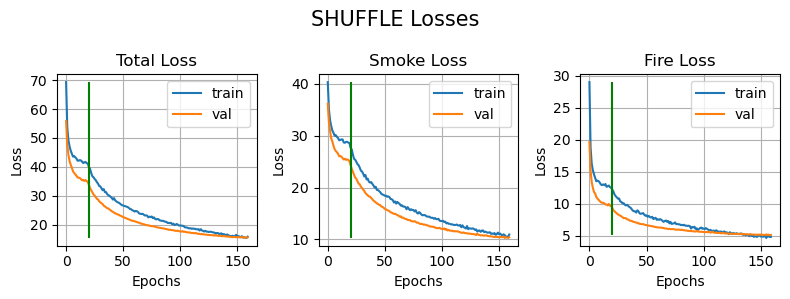

In [26]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.vlines(x=20, ymin=min(val_total_loss), ymax=max(train_total_loss), color='green')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.vlines(x=20, ymin=min(val_smoke_loss), ymax=max(train_smoke_loss), color='green')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.vlines(x=20, ymin=min(val_fire_loss), ymax=max(train_fire_loss), color='green')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()